# MNSIT读取和MyLeNet模板

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import timeit
%matplotlib inline

import torch.nn.functional as F

# 载入数据

In [2]:
set_train = dset.MNIST('./MNIST', train=True, transform=T.ToTensor(), download=True)
loader_train = DataLoader(set_train, batch_size=64)
set_test = dset.MNIST('./MNIST', train=False, transform=T.ToTensor(),download=True)
loader_test = DataLoader(set_test, batch_size=64)

### 看下大小

In [3]:
print("训练集大小：",set_train.train_data.size())
print("训练集标签：",set_train.train_labels.size())
print("测试集大小：",set_test.test_data.size())
print("测试集标签：",set_test.test_labels.size())
type(set_train[0]) #数据集的索引是tuple

训练集大小： torch.Size([60000, 28, 28])
训练集标签： torch.Size([60000])
测试集大小： torch.Size([10000, 28, 28])
测试集标签： torch.Size([10000])


tuple

# 显示MNIST数据集图像

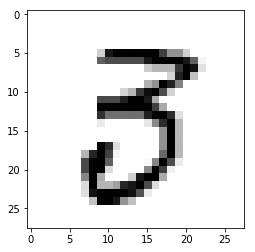

In [4]:
i=np.random.randint(0,60000) #随机数
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")

# 初始化一些参数

In [50]:
# 打印loss的频率
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # 读取 N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def train(model, loss_fn, optimizer, num_epochs = 5):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        check_accuracy(model, loader_test)
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
                   
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# 构造模型 MyLeNet

In [51]:
# MyNeLet
Net_base = nn.Sequential( 
                    nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), #conv1
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2,stride=2), #pool1
                    nn.BatchNorm2d(32), #bn1
                    nn.Conv2d(32, 32, kernel_size=5, stride=1,padding=0), #conv2
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2,stride=2), #pool2
                    nn.BatchNorm2d(32), #bn2
                    Flatten(), 
                    nn.Linear(800, 400),
                    nn.ReLU(inplace=True),
                    nn.Linear(400, 10),                                     
            )
dtype = torch.cuda.FloatTensor#设置数据类型，cuda是gpu版
Net =Net_base.type(dtype) #实例化模型

x = torch.randn(64, 1, 28, 28).type(dtype) #测试模型是否架构数据
x_var = Variable(x.type(dtype)) # 变量化
ans = Net(x_var)        # 喂入模型

# 应该相等
print(ans.size())
np.array_equal(np.array(ans.size()), np.array([64, 10]))

torch.Size([64, 10])


True

# 训练

In [60]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = torch.optim.Adam(Net.parameters(), lr=1e-5)

#torch.cuda.random.manual_seed(123)
#Net.apply(reset) #重置权值
train(Net, loss_fn, optimizer, num_epochs=10)
check_accuracy(Net, loader_test)

Starting epoch 1 / 10
Checking accuracy on test set


/Users/lhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 9937 / 10000 correct (99.37)
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0000
t = 500, loss = 0.0000
t = 600, loss = 0.0000
t = 700, loss = 0.0000
t = 800, loss = 0.0000
t = 900, loss = 0.0000
Starting epoch 2 / 10
Checking accuracy on test set
Got 9935 / 10000 correct (99.35)
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0000
t = 500, loss = 0.0000
t = 600, loss = 0.0000
t = 700, loss = 0.0000
t = 800, loss = 0.0000
t = 900, loss = 0.0000
Starting epoch 3 / 10
Checking accuracy on test set
Got 9936 / 10000 correct (99.36)
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0000
t = 500, loss = 0.0000
t = 600, loss = 0.0000
t = 700, loss = 0.0000
t = 800, loss = 0.0000
t = 900, loss = 0.0000
Starting epoch 4 / 10
Checking accuracy on test set
Got 9936 / 10000 correct (99.36)
t = 100, loss = 0.0000
t = 200, loss = 0.0000
t = 300, loss = 0.0000
t = 400, loss = 0.0000

# 可视化预测

根据图像预测的数字： [[5]]


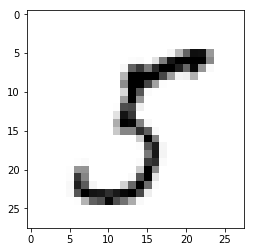

In [166]:
i = np.random.randint(0,60000) #随机数
x = set_train.train_data[i].view([1,1,28,28])
x_var = Variable(x.type(dtype))
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")
scores = Net(x_var) #结果scores是个var
s, i = scores.data.cpu().max(1) #取var的data，放入cpu，计算最大的索引i和分数s
print("根据图像预测的数字：",i.numpy())

In [12]:
from torchvision import models
net2 = models.alexnet(pretrained=False)

In [13]:
train(net2, loss_fn, optimizer, num_epochs=5)

Starting epoch 1 / 5
Checking accuracy on test set


/Users/lhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 9834 / 10000 correct (98.34)


RuntimeError: Given groups=1, weight[64, 3, 11, 11], so expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [29]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net3 = Net3().cuda()

In [43]:
optimizer = torch.optim.Adam(net3.parameters(), lr=1e-3)
#net3.apply(reset)
train(net3, loss_fn, optimizer, num_epochs=20)

Starting epoch 1 / 20
Checking accuracy on test set


/Users/lhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Got 9904 / 10000 correct (99.04)
t = 100, loss = 0.0699
t = 200, loss = 0.0350
t = 300, loss = 0.0783
t = 400, loss = 0.1883
t = 500, loss = 0.0607
t = 600, loss = 0.1489
t = 700, loss = 0.0330
t = 800, loss = 0.0300
t = 900, loss = 0.0254
Starting epoch 2 / 20
Checking accuracy on test set
Got 9896 / 10000 correct (98.96)
t = 100, loss = 0.1511
t = 200, loss = 0.0408
t = 300, loss = 0.0627
t = 400, loss = 0.1784
t = 500, loss = 0.2072
t = 600, loss = 0.1417
t = 700, loss = 0.0587
t = 800, loss = 0.0679
t = 900, loss = 0.0461
Starting epoch 3 / 20
Checking accuracy on test set
Got 9899 / 10000 correct (98.99)
t = 100, loss = 0.0192
t = 200, loss = 0.0381
t = 300, loss = 0.0296
t = 400, loss = 0.2054
t = 500, loss = 0.1741
t = 600, loss = 0.1560
t = 700, loss = 0.0718
t = 800, loss = 0.1202
t = 900, loss = 0.1440
Starting epoch 4 / 20
Checking accuracy on test set
Got 9907 / 10000 correct (99.07)
t = 100, loss = 0.0678
t = 200, loss = 0.0916
t = 300, loss = 0.0357
t = 400, loss = 0.2575

KeyboardInterrupt: 